## 1. Image Quality Evaluation

In this section, we evaluate the performance of our image deblurring model. The goal is to assess the quality of the images predicted by the model using various quality metrics. These metrics help us understand how well the model restores the sharpness and structure of the original image compared to the noisy, blurry input.

### Key Evaluation Metrics:
- **PSNR (Peak Signal-to-Noise Ratio)**: Measures the ratio between the maximum possible power of a signal (image) and the power of noise (error).
- **SSIM (Structural Similarity Index)**: Quantifies the perceptual quality of an image, focusing on the structural information and texture similarities between the target and predicted images.
- **LPIPS (Learned Perceptual Image Patch Similarity)**: Measures perceptual similarity between images by comparing feature representations at multiple layers in a neural network.

In this part, we calculate these metrics for the model’s output on a validation set and visualize them to assess its performance.

---

## 2. Prediction of Image Deblurring Quality

This section covers the process of predicting the quality of deblurred images using a trained model. The model's predictions (PSNR, SSIM, and LPIPS values) are compared to the ground truth (clean) images in order to quantify its effectiveness in restoring image sharpness.

### Steps:
1. **Model Training**: We train a neural network designed for image deblurring, using the PSNR, SSIM, and LPIPS metrics as outputs.
2. **Evaluation**: After training the model, we use it to predict the quality metrics for the validation images. This allows us to assess the overall performance of the model in predicting these metrics.

These predictions give us insight into how well the model can deblur images and how close its predictions are to the true quality metrics.

---

## 3. Causal Inference using Regression Discontinuity Design (RD)

In this section, we use **Regression Discontinuity Design (RD)** to estimate the causal effect of treatment (such as applying a noise reduction technique) on the outcome variable (PSNR). RD is a statistical method used when treatment assignment is based on a cutoff value, allowing for causal inference in quasi-experimental settings.

### Key Steps in RD Analysis:
1. **Simulating Data**: We generate synthetic data that simulates the relationship between treatment and outcome variables. This includes treatment assignment based on a cutoff value, along with other factors like noise and blur levels.
2. **Plotting the RD**: We visualize the data using an RD plot, which helps identify whether a discontinuity at the cutoff exists and estimate the treatment effect.
3. **Running the RD Analysis**: Using the `rdrobust` package, we estimate the treatment effect at the cutoff and examine the results to make inferences about the causal relationship between the treatment and outcome.

The RD analysis helps us estimate the causal impact of treatment on the PSNR and provides insight into the effectiveness of the treatment applied to the images.


In [6]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips  # For calculating LPIPS (Learned Perceptual Image Patch Similarity)
from rdrobust import rdrobust, rdplot  # For Regression Discontinuity Analysis

In [8]:
# Paths to the dataset (Replace with your own paths when running the notebook)
input_dir = '/Users/zhanglin/Documents/dku/2024-2025/session3/STATS 201/reflection/week2/mini/input_noise'  # Folder containing blurry images
target_dir = '/Users/zhanglin/Documents/dku/2024-2025/session3/STATS 201/reflection/week2/mini/target'      # Folder containing clean images

# Get the list of filenames in the dataset
input_files = os.listdir(input_dir)
target_files = os.listdir(target_dir)


In [10]:
# Custom Dataset Class
class BlurredImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_files = os.listdir(input_dir)
        self.target_files = os.listdir(target_dir)

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_files[idx])
        target_image_path = os.path.join(self.target_dir, self.target_files[idx])
        
        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
        
        return input_image, target_image

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
# Load Dataset
dataset = BlurredImageDataset(input_dir, target_dir, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Define WEDDM Model (Simplified for demonstration)
class WEDDM(nn.Module):
    def __init__(self):
        super(WEDDM, self).__init__()
        self.denoise_module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )
        self.diffusion_module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        denoised = self.denoise_module(x)
        output = self.diffusion_module(denoised)
        return output

# Initialize Model, Loss, and Optimizer
model = WEDDM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [13]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [10/80], Loss: 0.1901
Epoch [1/10], Step [20/80], Loss: 0.1434
Epoch [1/10], Step [30/80], Loss: 0.0958
Epoch [1/10], Step [40/80], Loss: 0.0362
Epoch [1/10], Step [50/80], Loss: 0.0500
Epoch [1/10], Step [60/80], Loss: 0.0317
Epoch [1/10], Step [70/80], Loss: 0.0326
Epoch [1/10], Step [80/80], Loss: 0.0234
Epoch [2/10], Step [10/80], Loss: 0.0241
Epoch [2/10], Step [20/80], Loss: 0.0192
Epoch [2/10], Step [30/80], Loss: 0.0258
Epoch [2/10], Step [40/80], Loss: 0.0223
Epoch [2/10], Step [50/80], Loss: 0.0190
Epoch [2/10], Step [60/80], Loss: 0.0161
Epoch [2/10], Step [70/80], Loss: 0.0204
Epoch [2/10], Step [80/80], Loss: 0.0191
Epoch [3/10], Step [10/80], Loss: 0.0170
Epoch [3/10], Step [20/80], Loss: 0.0129
Epoch [3/10], Step [30/80], Loss: 0.0140
Epoch [3/10], Step [40/80], Loss: 0.0208
Epoch [3/10], Step [50/80], Loss: 0.0186
Epoch [3/10], Step [60/80], Loss: 0.0107
Epoch [3/10], Step [70/80], Loss: 0.0187
Epoch [3/10], Step [80/80], Loss: 0.0105
Epoch [4/10], St

Validation Loss: 0.0113


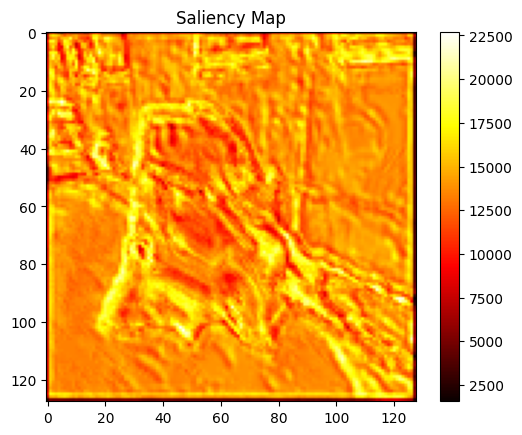

In [15]:
# Evaluation
model.eval()
val_loss = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, targets).item()
val_loss /= len(val_loader)
print(f'Validation Loss: {val_loss:.4f}')

# Explanation: Saliency Maps
def generate_saliency_map(model, image):
    # Ensure image requires gradient
    image.requires_grad_()
    # Forward pass
    output = model(image)
    # Get the index of the maximum value along the channel dimension (dim=1)
    output_idx = output.argmax(dim=1)  # Shape: [batch_size, height, width]
    # Select the maximum value for each spatial location
    output_max = output[0, output_idx[0]].sum()  # Sum over spatial dimensions
    # Backward pass to compute gradients
    output_max.backward()
    # Get the absolute value of gradients and take the maximum along channels
    saliency, _ = torch.max(image.grad.data.abs(), dim=1)  # Shape: [batch_size, height, width]
    return saliency

# Generate Saliency Map for a Sample Image
sample_image, _ = val_dataset[0]
sample_image = sample_image.unsqueeze(0)  # Add batch dimension
saliency_map = generate_saliency_map(model, sample_image)

# Visualize Saliency Map
plt.imshow(saliency_map.squeeze().numpy(), cmap='hot')
plt.title('Saliency Map')
plt.colorbar()
plt.show()


In [16]:
# Set device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple neural network model for predicting deblurring quality
class DeblurringNet(nn.Module):
    def __init__(self):
        super(DeblurringNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 3)  # Output: PSNR, SSIM, LPIPS
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, and Optimizer
model = DeblurringNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Prediction and Evaluation using PSNR, SSIM, LPIPS
def evaluate_model(model, val_loader):
    model.eval()
    psnr_values = []
    ssim_values = []
    lpips_values = []
    lpips_model = lpips.LPIPS(net='vgg').to(device)  # Make sure LPIPS is initialized here
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass to get predicted quality metrics
            outputs = model(inputs)  # Shape: [batch_size, 3] (PSNR, SSIM, LPIPS predictions)
            
            # Calculate ground truth quality metrics
            # PSNR
            psnr_value = psnr(targets.cpu().numpy(), inputs.cpu().numpy(), data_range=1.0)
            psnr_values.append(psnr_value)
            
            # SSIM
            # Ensure inputs and targets are in [height, width, channels] format
            inputs_np = inputs.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to [batch_size, height, width, channels]
            targets_np = targets.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to [batch_size, height, width, channels]
            
            # Calculate SSIM for each image in the batch
            for i in range(inputs_np.shape[0]):
                ssim_value = ssim(targets_np[i], inputs_np[i], data_range=1.0, channel_axis=-1)
                ssim_values.append(ssim_value)
            
            # LPIPS
            lpips_batch = lpips_model(inputs, targets)  # Shape: [batch_size]
            for lpips_value in lpips_batch:
                lpips_values.append(lpips_value.item())  # Append each LPIPS value individually
    
    mean_psnr = np.mean(psnr_values)
    mean_ssim = np.mean(ssim_values)
    mean_lpips = np.mean(lpips_values)
    
    return mean_psnr, mean_ssim, mean_lpips

# Assuming val_loader is already defined in your notebook
mean_psnr, mean_ssim, mean_lpips = evaluate_model(model, val_loader)
print(f'Mean PSNR: {mean_psnr:.4f}')
print(f'Mean SSIM: {mean_ssim:.4f}')
print(f'Mean LPIPS: {mean_lpips:.4f}')


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


/opt/anaconda3/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Mean PSNR: 19.5910
Mean SSIM: 0.7345
Mean LPIPS: 0.2301


Min Noise Level: 0.004632023004602859, Max Noise Level: 0.9997176732861306


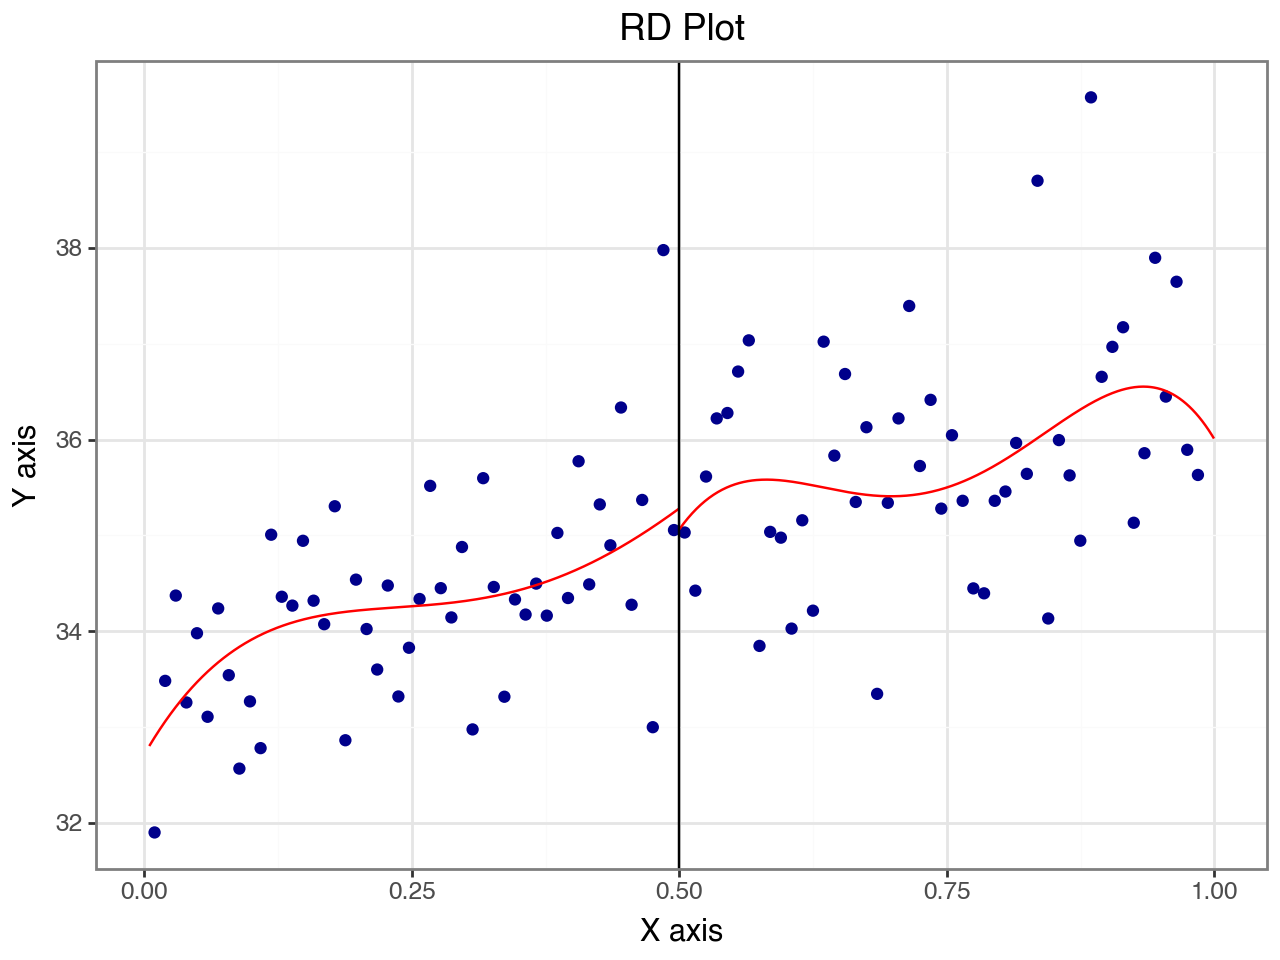

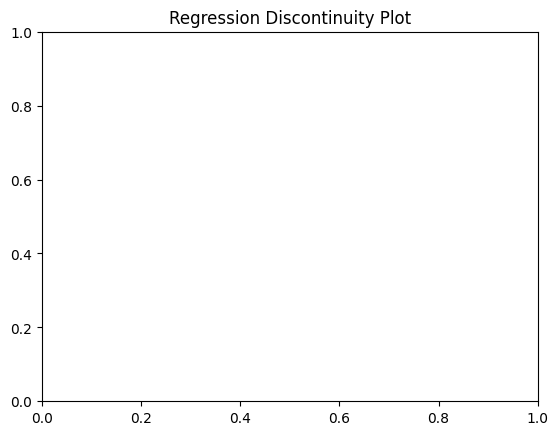

RD Analysis Results: Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           503        497
Number of Unique Obs.            503        497
Number of Effective Obs.         170        192
Bandwidth Estimation            0.18       0.18
Bandwidth Bias                 0.261      0.261
rho (h/b)                      0.688      0.688

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional        0.15    0.666    0.226   8.213e-01    [-1.154, 1.455]
Robust                 -        -    0.169   8.657e-01    [-1.435, 1.706]



In [17]:
# Simulate Data for RD Analysis
np.random.seed(42)
n_samples = 1000
cutoff = 0.5  # Default cutoff value
noise_level = np.random.rand(n_samples)  # Simulate noise level
blur_level = np.random.rand(n_samples)  # Simulate blur level
treatment = np.random.rand(n_samples) > cutoff  # Create a treatment variable based on the cutoff
psnr_values = 30 + 5 * treatment + 3 * noise_level + 2 * blur_level + np.random.normal(0, 1, n_samples)  # Simulate PSNR values

# Create DataFrame for RD Analysis
data = pd.DataFrame({
    'treatment': treatment,
    'noise_level': noise_level,
    'blur_level': blur_level,
    'psnr': psnr_values
})

# Check the min and max values of noise_level to ensure cutoff is within range
min_noise = data['noise_level'].min()
max_noise = data['noise_level'].max()
print(f'Min Noise Level: {min_noise}, Max Noise Level: {max_noise}')

# Adjust cutoff if necessary (ensure it lies within the range of noise_level)
if cutoff < min_noise or cutoff > max_noise:
    print(f"Adjusting cutoff value from {cutoff} to be within the range [{min_noise}, {max_noise}]")
    cutoff = (min_noise + max_noise) / 2  # Set cutoff to the midpoint

# Plot the Regression Discontinuity (RD) plot with adjustments
rdplot(data['psnr'], data['noise_level'], masspoints=True, nbins=50, c=cutoff)  # Specify cutoff value
plt.title('Regression Discontinuity Plot')
plt.show()

# Perform Regression Discontinuity Analysis using rdrobust
rd_results = rdrobust(data['psnr'], data['noise_level'], c=cutoff)

# Display RD Analysis Results
print("RD Analysis Results:", rd_results)
